In [43]:
import numpy as np
import os
import pickle
import re
import pandas as pd

%matplotlib inline
from IPython.display import display, HTML
import matplotlib
matplotlib.use("pgf")
matplotlib.rcParams.update({
    "pgf.texsystem": "pdflatex",
    "pgf.preamble": "\n".join([
        r"\usepackage[T2A]{fontenc}",
        r"\usepackage[utf8]{inputenc}",
        r"\usepackage[english,russian]{babel}",
    ]),
    'font.family': 'serif',
    'text.usetex': True,
    'pgf.rcfonts': False,
    'figure.figsize': [4.75, 4.75 * 9 / 16],
    'figure.dpi': 200
})

from matplotlib import pyplot as plt
from utils.various import datafiles
from components import CrocLens
import xrt.backends.raycing.materials as rm

from utils.xrtutils import get_integral_breadth

class ColorCycle:
    def __init__(self):
        self.cycle = plt.rcParams['axes.prop_cycle'].by_key()['color']
        self.ii = 0
    def current(self):
        return self.cycle[self.ii]
    def next(self):
        self.ii += 1
        self.ii = self.ii % len(self.cycle)
        return self.current()
    def reset(self):
        self.ii = 0

color_cycle = ColorCycle()

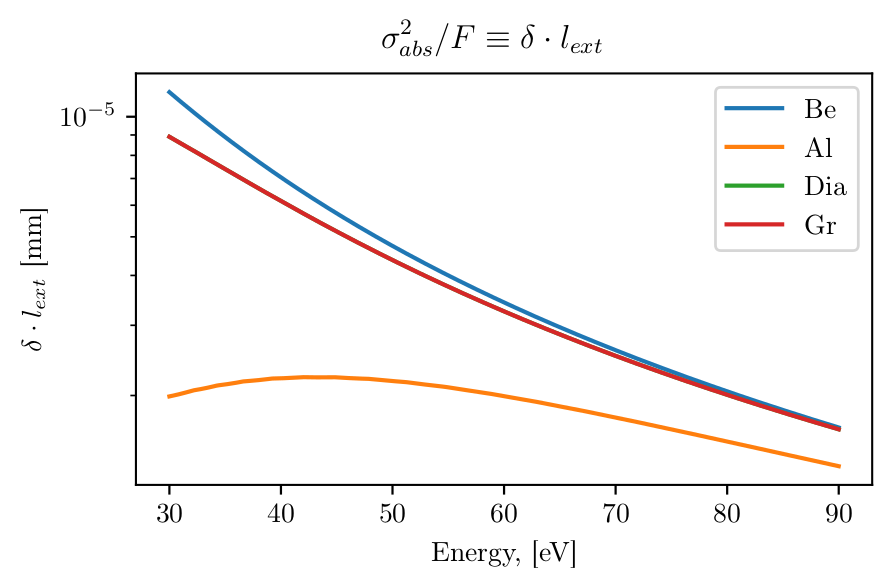

Al                             Be                        \
         Apt [mm]     L [mm]  y_t [mm]  Apt [mm]      L [mm]  y_t [mm]   
E [keV]                                                                  
30       1.001405   8.929917  0.273717   2.41026   82.242216  0.658804   
35       1.036582  13.030645  0.283332  2.116677   86.333604  0.578559   
40       1.055139   17.64132  0.288405  1.884684    89.40025  0.515147   
45       1.057955  22.452939  0.289174  1.698356   91.881661  0.464217   
50       1.046803  27.144013  0.286126  1.546168   94.016231  0.422619   
55        1.02795  31.676905  0.280973  1.419796   95.924605  0.388078   
60       1.002026  35.825227  0.273887  1.313435   97.695354  0.359005   
65        0.97294  39.643438  0.265937  1.222667   99.357304  0.334196   
70       0.942026  43.105127  0.257487   1.14431  100.934795  0.312778   
75       0.910416  46.220915  0.248847  1.076046  102.457358  0.294119   
80        0.87897  49.021651  0.240252  1.016049  103.936608   0.27772   
85       0.848264   51.54436  0.231859  0.962887  105.377526  0.263189   
90        0.81868  53.828416  0.223773  0.915456  106.787571  0.250225   

              Dia                             Gr                       
         Apt [mm]     L [mm]  y_t [mm]  Apt [mm]     L [mm]  y_t [mm]  
E [keV]                                                                
30       2.118662  29.804813  0.579101  2.118662  48.519463  0.579101  
35       1.930081  33.669886  0.527556  1.930081  54.811442  0.527556  
40       1.760024  36.570798  0.481073  1.760024  59.533857  0.481073  
45       1.611991  38.827845  0.440611  1.611991   63.20812  0.440611  
50        1.48433   40.64483  0.405717   1.48433  66.166003  0.405717  
55       1.374697  42.184439   0.37575  1.374697  68.672343   0.37575  
60       1.279994  43.524943  0.349865  1.279994  70.854559  0.349865  
65       1.197698  44.724614  0.327371  1.197698  72.807512  0.327371  
70       1.125682  45.820203  0.307686  1.125682  74.591028  0.307686  
75        1.06225   46.83916  0.290348   1.06225  76.249796  0.290348  
80       1.005973  47.795668  0.274966  1.005973  77.806902  0.274966  
85        0.95575  48.704011  0.261238   0.95575  79.285599  0.261238  
90       0.910672  49.573526  0.248917  0.910672   80.70109  0.248917

,y_t [mm],L [mm]
Be,0.66,107
Al,0.29,54
Dia,0.58,50
Gr,0.58,81


In [44]:
mBeryllium = rm.Material('Be', rho=1.848, kind='lens')
mAl = rm.Material('Al', rho=2.7, kind='lens')
mDiamond = rm.Material('C', rho=3.5, kind='lens')
mGraphite = rm.Material('C', rho=2.15, kind='lens')

fdist = 14.e3  # mm
ens = np.array([30., 35., 40., 45., 50., 55., 60., 65., 70., 75., 80., 85., 90.]) * 1.e3 # eV
optimal_geometry = pd.DataFrame(
    columns=pd.MultiIndex.from_product([['Be', 'Al', 'Dia', 'Gr'], ['y_t [mm]', 'L [mm]', 'Apt [mm]']]),
)
optimal_geometry['E [keV]'] = (ens * 1e-3).astype(int)
optimal_geometry = optimal_geometry.set_index('E [keV]')
optimal_geometry = optimal_geometry.sort_index(axis=1)

for mat, cpt in zip((mBeryllium, mAl, mDiamond, mGraphite), ('Be', 'Al', 'Dia', 'Gr')):
    for en_ in ens:
        opt_pars = CrocLens.calc_optimal_params(mat, fdist, en_)
        optimal_geometry.loc[int(1e-3 * en_), (cpt, 'y_t [mm]')] = opt_pars['y_t']
        optimal_geometry.loc[int(1e-3 * en_), (cpt, 'L [mm]')] = opt_pars['L']
        optimal_geometry.loc[int(1e-3 * en_), (cpt, 'Apt [mm]')] = opt_pars['Aperture']

fixed_geometry = pd.DataFrame(index=['Be', 'Al', 'Dia', 'Gr'], columns=['y_t [mm]', 'L [mm]'])
for m_name in ['Be', 'Al', 'Dia', 'Gr']:
    fixed_geometry.loc[m_name, 'y_t [mm]'] = np.round(np.max(optimal_geometry.loc[:, (m_name, 'y_t [mm]')]), decimals=2)
    fixed_geometry.loc[m_name, 'L [mm]'] = int(np.round(np.max(optimal_geometry.loc[:, (m_name, 'L [mm]')]), decimals=0))

fig, ax = plt.subplots(nrows=1, ncols=1)
ens_ = np.linspace(ens[0], ens[-1], 300)
for mat, cpt in zip((mBeryllium, mAl, mDiamond, mGraphite), ('Be', 'Al', 'Dia', 'Gr')):
    abs_len = 10. / mat.get_absorption_coefficient(ens_)  # mm
    delta = np.real(1. - mat.get_refractive_index(ens_))
    ax.semilogy(ens_ * 1e-3, delta * abs_len, label=cpt)
ax.legend()
plt.suptitle('$\sigma^{2}_{abs} / F \equiv \delta  \cdot l_{ext}$')
ax.set_ylabel('$\delta \cdot l_{ext}$ [mm]')
ax.set_xlabel('Energy, [eV]')

display(HTML('<center><h1>Lens param optimization</h1></center>'))
display(fig)
display(optimal_geometry)
display(fixed_geometry)

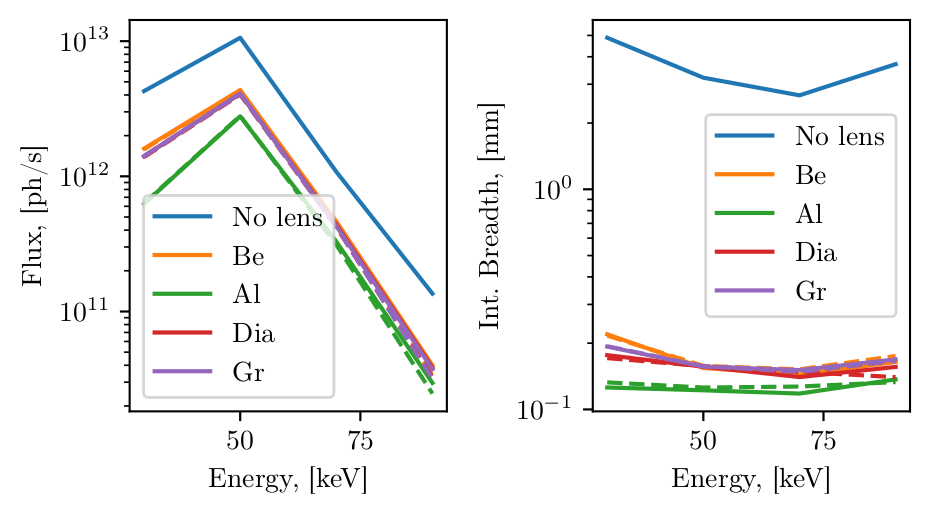

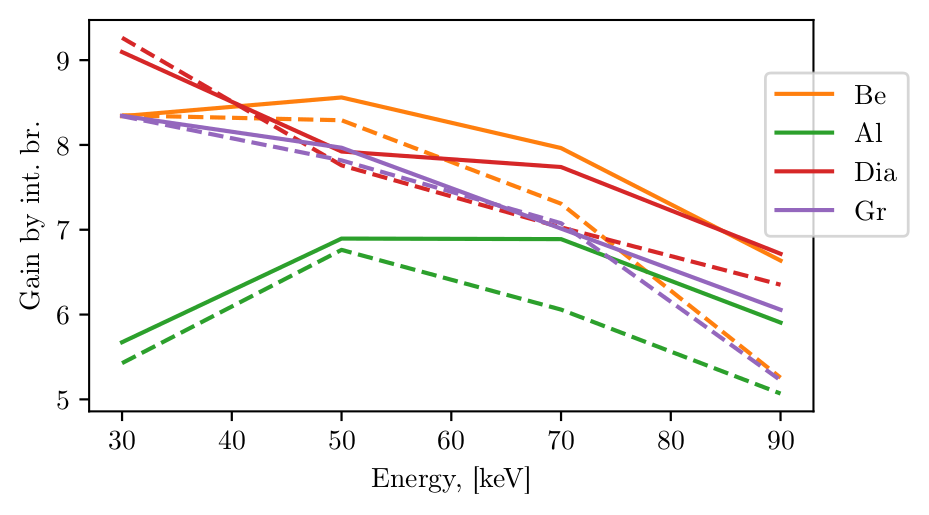

In [60]:
def get_data(wd):
    en, flux, breadth = [], [], []
    for f_name in os.listdir(wd):
        rmo = re.match(r'FM-XZ-(?P<ee>[\d]+)keV-.+.pickle', f_name)
        if rmo is None:
            continue
        with open(os.path.join(wd, f_name), 'rb') as f:
            f = pickle.load(f)
            flux.append(f.flux)
            breadth.append(get_integral_breadth(f, 'y'))
            en.append(int(rmo.groupdict()['ee']))
    flux, breadth, en = np.array(flux), np.array(breadth), np.array(en)
    ii = np.argsort(en)
    flux, breadth, en = flux[ii], breadth[ii], en[ii]
    return flux, breadth, en

fl_ref, br_ref, en_ref = get_data(os.path.join(os.getenv('BASE_DIR'), 'datasets', 'nstu-scw', 'lens_e_scan_no_lens'))
fig1, (ax1, ax2) = plt.subplots(ncols=2, nrows=1)
fig2, ax3 = plt.subplots(ncols=1, nrows=1)

color_cycle.reset()
ax1.plot(en_ref, fl_ref, label='No lens', color=color_cycle.current())
ax2.plot(en_ref, br_ref, label='No lens', color=color_cycle.current())

for wd_, lbl in zip(('lens_e_scan_be', 'lens_e_scan_al', 'lens_e_scan_dia', 'lens_e_scan_gr',), ('Be', 'Al', 'Dia', 'Gr')):
    fl_, br_, en_ = get_data(os.path.join(os.getenv('BASE_DIR'), 'datasets', 'nstu-scw', wd_))
    ax1.semilogy(en_, fl_, label=lbl, color=color_cycle.next())
    ax2.semilogy(en_, br_, label=lbl, color=color_cycle.current())
    ax3.plot(en_, (fl_ / br_) / (fl_ref / br_ref), label=lbl, color=color_cycle.current())
    
    fl_, br_, en_ = get_data(os.path.join(os.getenv('BASE_DIR'), 'datasets', 'nstu-scw', 'mask_' + wd_))
    ax1.semilogy(en_, fl_, label=None, color=color_cycle.current(), linestyle='--')
    ax2.semilogy(en_, br_, label=None, color=color_cycle.current(), linestyle='--')
    ax3.plot(en_, (fl_ / br_) / (fl_ref / br_ref), label=None, color=color_cycle.current(), linestyle='--')

ax1.set_xlabel('Energy, [keV]')
ax2.set_xlabel('Energy, [keV]')
ax3.set_xlabel('Energy, [keV]')
ax1.set_ylabel('Flux, [ph/s]')
ax2.set_ylabel('Int. Breadth, [mm]')
ax3.set_ylabel('Gain by int. br.')
ax1.legend()
ax2.legend()
# fig2.legend(bbox_to_anchor=(1.15, .9))
ax3.legend(bbox_to_anchor=(1.15, .9))
fig1.tight_layout()
fig2.tight_layout()

display(HTML('<center><h1>Gain</h1></center>'))
display(fig1)
display(fig2)

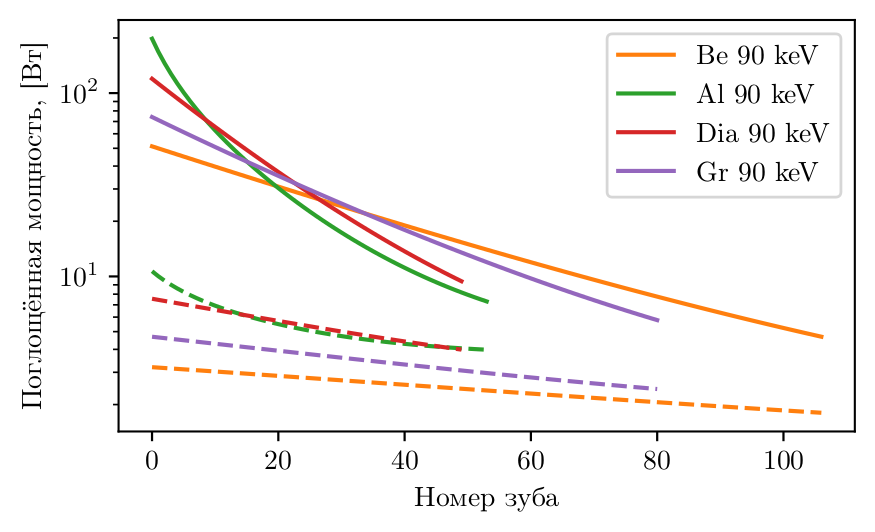

In [50]:
def get_data(wd):
    nn, pabs, en = [], [], []
    for f_name in os.listdir(wd):
        rmo = re.match(r'LensAbs_(?P<nn>[\d]+)-XZ-(?P<ee>[\d]+)keV-.+.pickle', f_name)
        if rmo is None:
            continue
        with open(os.path.join(wd, f_name), 'rb') as f:
            f = pickle.load(f)
            pabs.append(f.power)
            nn.append(int(rmo.groupdict()['nn']))
            en.append(int(rmo.groupdict()['ee']))
    nn, pabs, en = np.array(nn), np.array(pabs), np.array(en)
    ii = np.argsort(nn)
    nn, pabs, en = nn[ii], pabs[ii], en[ii]
    return nn, pabs, en

color_cycle.reset()
fig = plt.figure()
for wd_, lbl in zip(('lens_abs_e_scan_be', 'lens_abs_e_scan_al', 'lens_abs_e_scan_dia', 'lens_abs_e_scan_gr',), ('Be', 'Al', 'Dia', 'Gr')):
    xs, ys, ens = get_data(os.path.join(os.getenv('BASE_DIR'), 'datasets', 'nstu-scw', wd_))
    xs_, ys_, ens_ = get_data(os.path.join(os.getenv('BASE_DIR'), 'datasets', 'nstu-scw', 'mask_' + wd_))
    for en in [90]:
        plt.semilogy(xs[ens == en], ys[ens == en], label=lbl + ' %d keV' % en, color=color_cycle.next())
        plt.semilogy(xs_[ens_ == en], ys_[ens_ == en], label=None, color=color_cycle.current(), linestyle='--')
plt.legend()
plt.xlabel('Номер зуба')
plt.ylabel('Поглощённая мощность, [Вт]')
fig